## X-Ray Diffraction Implementation

Python implementation of the virtual x-ray diffraction pattern algorithm, from http://dx.doi.org/10.1007/s11837-013-0829-3 and implemented in LAMMPS (in C++); https://github.com/lammps/lammps/tree/lammps-icms/src/USER-DIFFRACTION 

"This algorithm advances beyond previous virtual diffraction methods by using a high-resolution mesh of reciprocal space that eliminates the need for a priori knowledge of the crystal structure being modeled or other assumptions concerning the diffraction conditions. At each point on the reciprocal space mesh, the diffraction intensity is computed via explicit computation of the structure factor equation."

"X-ray diffraction line profiles are created by binning the intensity of each reciprocal lattice point by its associated scattering angle, effectively mimicking powder diffraction conditions."

The algorithm proceeds in the following manner:

1. Define a crystal structure by position (x,y,z) and atom/ion type.
2. Define the x-ray wavelength to use
3. Compute the full reciprocal lattice mesh
4. Filter reciprocal lattice points by those in the Eswald's sphere
5. Compute the structure factor at each reciprocal lattice point, for each atom type
6. Compute the x-ray diffraction intensity at each reciprocal lattice point
7. Group and sum intensities by angle

## Create a crystal structure and wavelength to analyse

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from IPython.display import Image
import ipymd
print ipymd.version()

0.1.1dev


In [2]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na1+', 'Cl1-'], 
    225, cellpar=[5.4, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])

sim_abc, sim_origin = data.get_simulation_box()
print sim_origin
print sim_abc
atoms_df = data.get_atom_data()
atoms_df.head(2)

[ 0.  0.  0.]
[[  2.70000000e+01   0.00000000e+00   0.00000000e+00]
 [  1.65327318e-15   2.70000000e+01   0.00000000e+00]
 [  1.65327318e-15   1.65327318e-15   2.70000000e+01]]


,id,type,x,y,z,transparency,color,radius
0,1,Na1+,0.000000e+00,0.0,0.0,1,light_salmon,1
1,2,Na1+,3.306546e-16,2.7,2.7,1,light_salmon,1


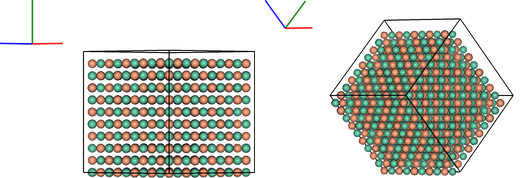

In [3]:
vis2 = ipymd.visualise_sim.Visualise_Sim()
vis2.add_axes()
vis2.add_box(sim_abc, sim_origin)
vis2.add_atoms(atoms_df)
images = [vis2.get_image(xrot=xrot,yrot=45) for xrot in [0,45]]
vis2.visualise(images, columns=2)

Define wavelength of incident x-ray (Cu $k\alpha$ radiation)

In [4]:
wlambda = 1.5405 # Angstrom ()

## Calculate full reciprocal lattice mesh

In [5]:
def set_thetas(min2theta=1.,max2theta=179.):
    """ set min and max angles to assess

    Properties
    ----------
    min2theta : float
        minimum 2 theta range to explore (degrees)
    max2theta : float
        maximum 2 theta range to explore (degrees)
    
    Returns
    -------
    min_theta : float
        minimum theta range to explore (radians)
    max_theta : float
        maximum theta range to explore (radians)

    """
    # Process angles
    min_theta = math.radians(min2theta) / 2.
    max_theta = math.radians(max2theta) / 2.
    return min_theta, max_theta

def compute_rmesh(sim_abc, wlambda, min_theta, max_theta,
                  rspace=[1,1,1], periodic=[True,True,True], manual=False):
    """Compute full reciprocal lattice mesh
    
    Properties
    ----------
    sim_abc : numpy.array((3,3))
        a,b,c cell vectors (length units)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    min_theta : float
        minimum theta range to explore (radians)
    max_theta : float
        maximum theta range to explore (radians)
    rspace : list of floats
        parameters to multiply the spacing of the reciprocal lattice nodes 
        in the h, k, and l directions respectively
    periodic : list of bools
        whether periodic boundary in the h, k, and l directions respectively
    manual : bool
        use manual spacing of reciprocal lattice points based on the values of the c parameters 
        (good for comparing diffraction results from multiple simulations, but small c required).
        
    Returns
    -------
    rmesh : np.array((N,3))
        mesh of k points defining reciprocal lattice
    
    """
    # get cell parameters
    a,b,c,alpha,beta,gamma = ipymd.atom_analysis.Atom_Analysis().calc_lattparams_bb(sim_abc)
    cell_lenghts = (a,b,c)
    if alpha!=90 or beta!=90 or gamma!=90:
        raise ValueError("Compute XRD does not work with triclinic structures")
    
    # maximum reciprocal lattice vector |K|, 
    # calculated from Bragg's law 
    Kmax = 2 * math.sin(max_theta) / wlambda 
        
    # Calculate spacing between reciprocal lattice points
    # Using distance based on periodic repeating distance
    if manual:
        inv_cell_lengths = [1.0,1.0,1.0]
    else:
        if not np.any(periodic):
            raise ValueError("Compute XRD must have at least one periodic boundary unless manual spacing specified")
        
        # calc inverse dimension for periodic directions
        inv_cell_lengths = [1./cell_lenghts[i] if periodic[i] else np.nan for i in range(3)]
        ave_inv = np.nanmean(inv_cell_lengths)

        # Use the average inverse dimensions for non-periodic directions
        inv_cell_lengths = [icl if periodic[i] else ave_inv for i,icl in enumerate(inv_cell_lengths)]
        
    # resolution (i.e. spacing) of reciprocal space points
    dK = [inv_cell_lengths[i] * rspace[i] for i in range(3)]
    # maximum integer value for K points in each dimension
    Knmax = [math.ceil(Kmax / dK[i]) for i in range(3)]
    
    # create the full reprocal lattice indices grid
    rmesh = np.mgrid[-Knmax[0]:Knmax[0]+1:1, 
               -Knmax[1]:Knmax[1]+1:1, 
               -Knmax[1]:Knmax[1]+1:1].reshape(3,-1).T
    
    # resize reciprocal mesh to correct spacing
    for i in range(3):
        rmesh[:,i] *= dK[i]
    
    return rmesh

(389017, 3)


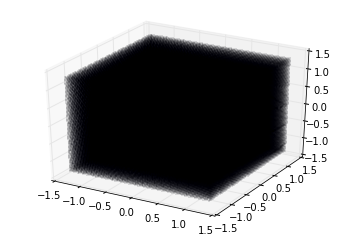

In [6]:
min_theta, max_theta = set_thetas()
rmesh = compute_rmesh(sim_abc,wlambda,min_theta, max_theta)
print rmesh.shape
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rmesh[:,0],rmesh[:,1],rmesh[:,2],
           s=0.1,marker='.',c='blue',depthshade=False)
plt.show()

## Restrict reciprocal mesh to Ewald's sphere

$\left| {\mathbf{K}} \right| = \frac{1}{{d_{\text{hkl}} }} = \frac{2\sin \left( \theta \right)}{\lambda } $

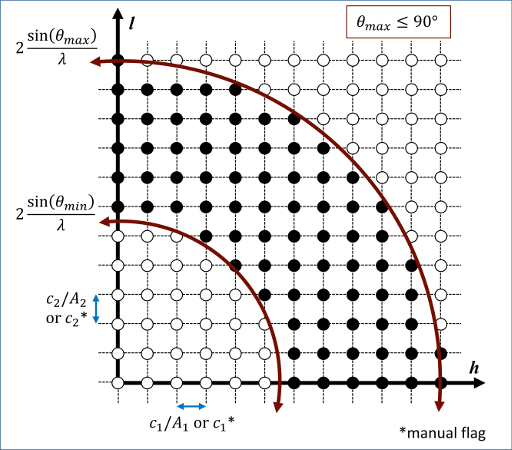

In [7]:
Image('xrd_mesh.jpg',width=300)

In [8]:
def restrict_rmesh(rmesh, wlambda, min_theta, max_theta):
    """filter mesh points to only those in Eswald's sphere 
    (and angular limits)
    
    Parameters
    ----------
    rmesh : np.array((N,3))
        mesh of k points defining reciprocal lattice
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    min_theta : float
        minimum theta range to explore (radians)
    max_theta : float
        maximum theta range to explore (radians)

    Returns
    -------
    rmesh_sphere : np.array((N,3))
        mesh of k points defining reciprocal lattice, 
        retricted to Eswald's shere (and angular limits)
    k_mods : np.array((N,1))
         modulus for each k-point
    thetas : np.array((N,1))
        angles for each k-point (radians)

    """
    # calculate the length (squared) of each mesh vector
    K_sqr = np.sum(np.square(rmesh),axis=1)
    # select only mesh points within the Eswald sphere radius
    radius_mask = K_sqr * wlambda**2 <= 2**2 # i.e. (2sin(pi))^2
    # calculate the angle of each remaining mesh vector
    K = np.sqrt(K_sqr[radius_mask])
    theta = np.arcsin(wlambda * np.sqrt(K_sqr[radius_mask]) * 0.5)
    # select only mesh points within the angular limits
    angle_mask = np.logical_and(theta <= max_theta, theta >= min_theta)
    # return remaining mesh points
    return rmesh[radius_mask][angle_mask], K[angle_mask], theta[angle_mask]

180250


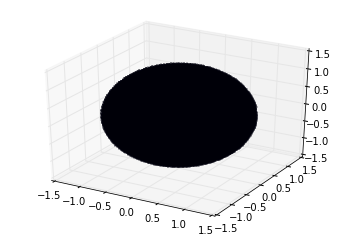

In [9]:
rmesh_sphere, k_mods, thetas = restrict_rmesh(rmesh,wlambda,min_theta, max_theta)
print len(rmesh_sphere)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rmesh_sphere[:,0],rmesh_sphere[:,1],rmesh_sphere[:,2],
           s=0.1,depthshade=False)
plt.show()

## Calculate the structure factors for each reciprocal mesh point

The atomic scattering factors, fj, accounts for the reduction in diffraction intensity due to Compton scattering. 

$f_j \left(\frac{\sin \theta}{\lambda}\right) = \left[ \sum\limits^4_i a_i \exp \left( -b_i \frac{\sin^2 \theta}{\lambda^2} \right)\right] + c = \left[ \sum\limits^4_i a_i \exp \left( -b_i \left(\frac{\left| {\mathbf{K}} \right|}{2}\right)^2 \right)\right] + c$

Coefficients are based on the electron density around the atomic nuclei:

In [10]:
def get_sf_coeffs():
    return pd.read_csv('data/xray_scattering_factors_coefficients.csv',
                       index_col=0,comment='#')
sf_coeffs_df = get_sf_coeffs()
sf_coeffs_df.head(2)

,A1,B1,A2,B2,A3,B3,A4,B4,C
atype,,,,,,,,,
H,0.489918,20.6593,0.262003,7.74039,0.196767,49.5519,0.049879,2.20159,0.001305
He1-,0.897661,53.1368,0.565616,15.18700,0.415815,186.5760,0.116973,3.56709,0.002389


In [11]:
def calc_struct_factors(atoms_df,rmesh_sphere,wlambda,k_mods):
    """ calculate atomic scattering factors, fj, 
    for each atom at each reciprocal lattice point

    Parameters
    ----------
    atoms_df : pandas.DataFrame
        a dataframe of info for each atom, including columns; x,y,z,type
    rmesh_sphere : np.array((N,3))
        mesh of k points defining reciprocal lattice, 
        retricted to Eswald's shere (and angular limits)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    k_mods : np.array((N,1))
         modulus for each k-point, only required for calclating Lorentz-polarization factor

    Returns
    -------
    intensities : dict(np.array((N,1)))
         structure factor for each k-point (values), for each atom type (keys)

    """
    
    # calculate (|K|/2)^2
    K_2_sqr = (0.5*k_mods)**2

    # get the structure factor coefficients
    sf_coeffs_df = get_sf_coeffs()
    
    struct_factors = {}
    for atype in atoms_df.type.unique():
        sfs = sf_coeffs_df.loc[atype]
        struct_factors[atype] = 0
        struct_factors[atype] += sfs.A1 * np.exp(-sfs.B1*K_2_sqr)
        struct_factors[atype] += sfs.A2 * np.exp(-sfs.B2*K_2_sqr)
        struct_factors[atype] += sfs.A3 * np.exp(-sfs.B3*K_2_sqr)
        struct_factors[atype] += sfs.A4 * np.exp(-sfs.B4*K_2_sqr)
        struct_factors[atype] += sfs.C
    
    return struct_factors

In [12]:
struct_factors = calc_struct_factors(atoms_df,rmesh_sphere,wlambda,k_mods)
struct_factors

{'Cl1-': array([ 6.26722066,  6.26904317,  6.26722066, ...,  6.26722066,
         6.26904317,  6.26722066]),
 'Na1+': array([ 3.05391073,  3.0556127 ,  3.05391073, ...,  3.05391073,
         3.0556127 ,  3.05391073])}

## Compute for each atom

The relative diffraction intensity from x-rays is computed at each reciprocal lattice point through:

$I_x(\mathbf{K}) = Lp(\theta) \frac{F(\mathbf{K})F^*(\mathbf{K})}{N}$

such that:

$F ({\mathbf{K}} )= \sum\limits_{j = 1}^{N} {f_{j}.e^{\left( {2\pi i \, {\mathbf{K}} \cdot {\mathbf{r}}_{j} } \right)}} = \sum\limits_{j = 1}^{N} {f_j.\left[ \cos \left( 2\pi \mathbf{K} \cdot \mathbf{r}_j \right) + i \sin \left( 2\pi \mathbf{K} \cdot \mathbf{r}_j \right) \right]}$

and the Lorentz-polarization factor is:

$Lp(\theta) = \frac{1+\cos^2 (2\theta)}{\cos(\theta)\sin^2(\theta)}$

In [13]:
def calc_intensities(atoms_df, rmesh_sphere, wlambda, struct_factors,
                     thetas=None,k_mods=None,use_Lp=True):
    """ calculate diffraction intensities for each atom at each reciprocal lattice point

    Parameters
    ----------
    atoms_df : pandas.DataFrame
        a dataframe of info for each atom, including columns; x,y,z,type
    rmesh_sphere : np.array((N,3))
        mesh of k points defining reciprocal lattice, 
        retricted to Eswald's shere (and angular limits)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    k_mods : np.array((N,1))
         modulus for each k-point, only required for calclating Lorentz-polarization factor
    thetas : np.array((N,1))
        angles for each k-point (radians), only required for calclating Lorentz-polarization factor
    use_Lp : bool
        switch to apply Lorentz-polarization factor

    Returns
    -------
    intensities : np.array((N,1))
         intensity for each k-point

    """
    # compute F(K)
    F = np.zeros(rmesh_sphere.shape[0]) + 0*1j
    for xyz,atype in zip(atoms_df[['x','y','z']].values, atoms_df.type):
        inner_dot = 2 * np.pi * np.dot(xyz,rmesh_sphere.T)
        F += struct_factors[atype] * (np.cos(inner_dot) + 1j*np.sin(inner_dot))
    # compute Lp(theta)
    if use_Lp:
        sin_thetas = 0.5*k_mods*wlambda
        Lp = (1+np.cos(2*thetas)**2)/(np.cos(thetas)*sin_thetas**2)
    else:
        Lp = 1.
    # calculate intensities
    return Lp*F*np.conjugate(F)/float(atoms_df.shape[0])

In [14]:
I = calc_intensities(atoms_df,rmesh_sphere,wlambda,struct_factors,thetas,k_mods)
print I

[  2.78829174e-25 -1.17549435e-41j   2.59544600e-26 +0.00000000e+00j
   3.39895792e-26 +0.00000000e+00j ...,   3.39895792e-26 +0.00000000e+00j
   2.59544600e-26 +0.00000000e+00j   2.78829174e-25 +1.17549435e-41j]


## Full Algorithm and Testing

In [15]:
def compute_xrd(atoms_df, sim_abc,wlambda, min2theta=1.,max2theta=179.,
                rspace=[1,1,1], periodic=[True,True,True], manual=False, lp=True):
    """Compute predicted x-ray diffraction intensities for a given wavelength
    
    Properties
    ----------
    atoms_df : pandas.DataFrame
        a dataframe of info for each atom, including columns; x,y,z,type
    sim_abc : numpy.array((3,3))
        a,b,c cell vectors (length units)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    min2theta : float
        minimum 2 theta range to explore (degrees)
    max2theta : float
        maximum 2 theta range to explore (degrees)
    rspace : list of floats
        parameters to adjust the spacing of the reciprocal lattice nodes 
        in the h, k, and l directions respectively
    periodic : list of bools
        whether periodic boundary in the h, k, and l directions respectively
    manual : bool
        use manual spacing of reciprocal lattice points based on the values of the c parameters 
        (good for comparing diffraction results from multiple simulations, but small c required).
    lp : bool
        switch to apply Lorentz-polarization factor

    Returns
    -------
    2thetas : np.array((N,1))
        2theta angles for each k-point (degrees)
    intensities : np.array((N,1))
         intensity for each k-point

    """
    min_theta, max_theta = set_thetas(min2theta,max2theta)
    rmesh = compute_rmesh(sim_abc,wlambda,min_theta, max_theta,rspace, periodic, manual)
    rmesh_sphere, k_mods, thetas = restrict_rmesh(rmesh,wlambda,min_theta, max_theta)
    struct_factors = calc_struct_factors(atoms_df,rmesh_sphere,wlambda,k_mods)
    I = calc_intensities(atoms_df,rmesh_sphere,wlambda,struct_factors,thetas,k_mods,use_Lp=lp)
    
    return np.degrees(2*thetas), I

In [16]:
wlambda = 1.5405 # Angstrom ()
thetas, Is = compute_xrd(atoms_df,sim_abc,wlambda)

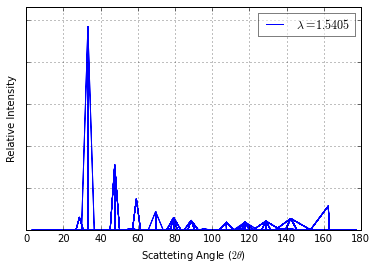

In [18]:
#ax = plt.scatter(x,y,s=10,label=r'$\lambda = {0}$'.format(wlambda))
ax = plt.plot(thetas,np.real(Is),
              label=r'$\lambda = {0}$'.format(wlambda))
ax = plt.gca()
ax.set_xlabel(r'Scatteting Angle ($2 \theta$)')
#ax.set_xlim(20,100)
ax.set_ylabel('Relative Intensity')
ax.set_ylim(1,np.real(Is).max()*1.1)
#ax.set_yscale('log')
ax.set_yticklabels([])
ax.legend(loc='upper right',framealpha=0.5)
#plt.minorticks_on()
plt.grid(True,'both')

Line profiles simulating x-ray powder diffraction are constructed by collecting reciprocal lattice points into bins corresponding to their scattering angle 2$\theta$ and summing the intensity data.

NB: the new numpy (v1.11.0) has an *auto* option to calculate the optimal bin width.

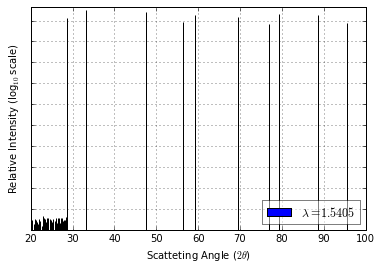

In [19]:
#x, y = np.histogram(thetas,bins='auto',weights=np.real(Is),density=True)
plt.hist(thetas,bins=180*100,weights=np.real(Is),normed=True,
         label=r'$\lambda = {0}$'.format(wlambda))
ax = plt.gca()
ax.set_xlabel(r'Scatteting Angle ($2 \theta$)')
ax.set_xlim(20,100)
ax.set_ylabel('Relative Intensity (log$_{10}$ scale)')
ax.set_yscale('log')
ax.set_yticklabels([])
ax.legend(loc='lower right',framealpha=0.5)
plt.grid(True)

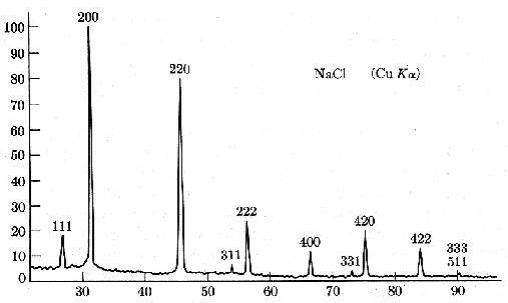

In [20]:
Image('xrd_nacl_Cu_kalpha.png',width=380)

In [26]:
data = ipymd.data_input.crystal.Crystal(
    [[0,0,0]], ['Fe'], 
    229, cellpar=[2.866, 2.866, 2.866, 90, 90, 90], 
    repetitions=[5,5,5])

sim_abc, sim_origin = data.get_simulation_box()
atoms_df = data.get_atom_data()

wlambda = 1.542 # Angstrom ()
thetas, Is = compute_xrd(atoms_df,sim_abc,wlambda)

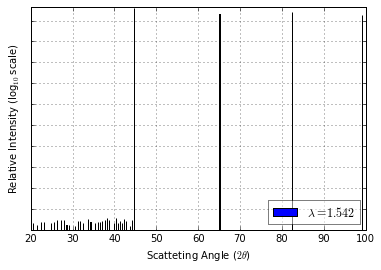

In [27]:
#x, y = np.histogram(thetas,bins='auto',weights=np.real(Is),density=True)
plt.hist(thetas,bins=180*100,weights=np.real(Is),normed=True,
         label=r'$\lambda = {0}$'.format(wlambda))
ax = plt.gca()
ax.set_xlabel(r'Scatteting Angle ($2 \theta$)')
ax.set_xlim(20,100)
ax.set_ylabel('Relative Intensity (log$_{10}$ scale)')
ax.set_yscale('log')
ax.set_yticklabels([])
ax.legend(loc='lower right',framealpha=0.5)
plt.grid(True)

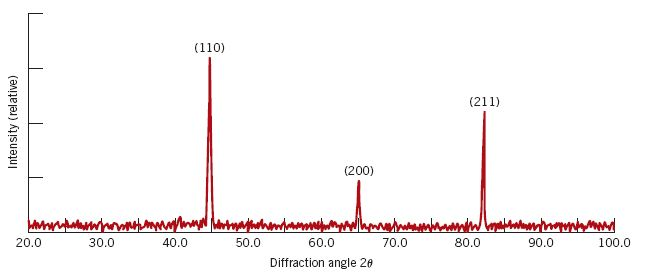

In [28]:
Image('xrd_fe_bcc_Cu_kalpha.png',width=380)

## TODO

- Averaging over (thermal) phase space
- Analysis of triclinic cells
- Calculation of structure factor coefficients from atom charge & type (rather than pre-defining ionic state)
- fast fourier transform?
- parallelization of fourier summation (http://ipyparallel.readthedocs.io/en/latest/intro.html#getting-started)